In [1]:
import sys
sys.path.append('/Users/celiaberon/GitHub/neural-timeseries-analysis/')
from nta.data.simulations import HeadfixedTask
from nta.events import align
from nta.visualization import avg_plots, heatmaps, peak_plots
from nta.events.quantify import group_peak_metrics
from nta.visualization.peak_plots import plot_peaks_wrapper
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

%load_ext autoreload
%autoreload 2


### Simulate behavior and neural data for headfixed task

In [2]:
ntrials = 1000

sim_data = HeadfixedTask()
sim_data.generate_session(total_trials=ntrials)
sim_data.convolve_kernel()

### Align neural data to behavior events

In [3]:
trials = sim_data.trials
trials.loc[trials.Reward<0, 'Reward'] = 0
trials['rand_variable'] = np.random.choice(['a','b','c','d'], size=len(trials))
timeseries = sim_data.session
win = (1,3)

for epoch in ['Cue', 'Select', 'Consumption']:
    trials = align.align_photometry_to_event(trials, timeseries, channel='grnL',
                                                aligned_event=epoch, window=win, quantify_peaks=False)
        
# Now it's ok to start dropping trials because we've stored photometry snippets.
timeseries_trimmed, trials_trimmed = align.trim_trials_without_licks(timeseries, trials) 


### Plot average and single-trial neural traces aligned to behavior events

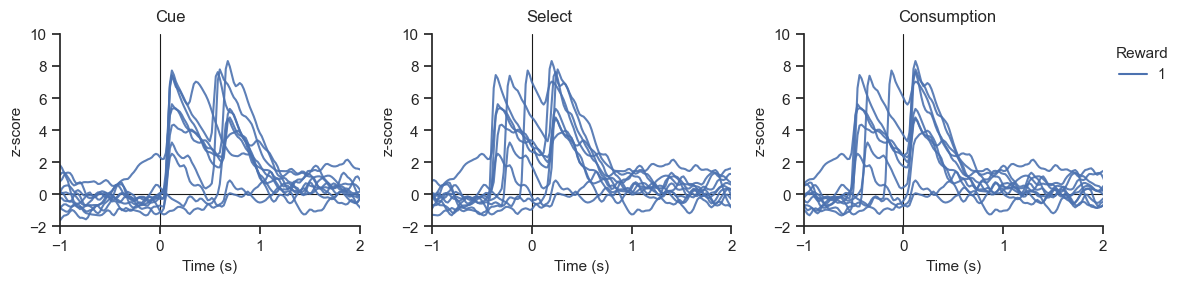

In [4]:
fig, axs = avg_plots.plotting_wrapper(trials_trimmed.sample(n=10),
                                    channel='grnL',
                                    column='Reward',
                                    window=(1,2),
                                    ylim=(-2,10),
                                    error='se',
                                    trial_units=True)


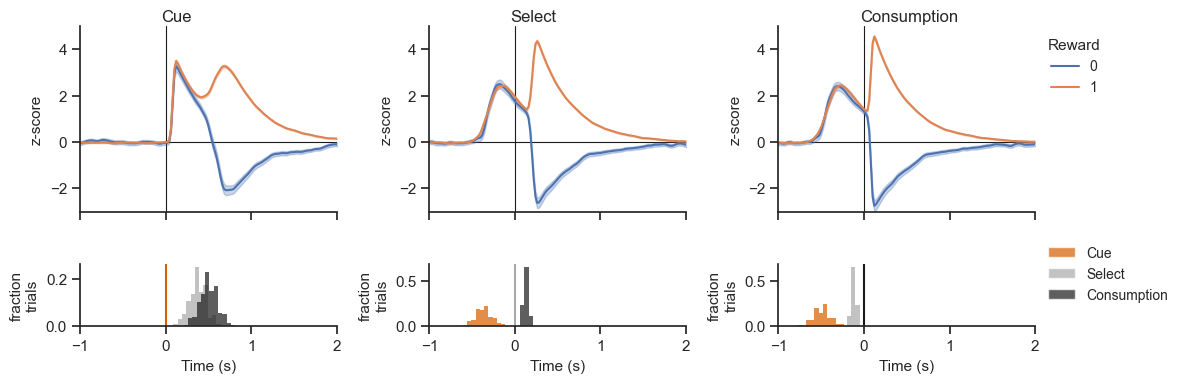

In [5]:
fig, axs = avg_plots.plotting_wrapper(trials_trimmed,
                                   channel='grnL',
                                   column='Reward',
                                   window=(1,2),
                                   ylim=(-3,5),
                                   error='se',
                                   behavior_hist=True,
                                   timeseries=timeseries_trimmed)


### Plot heatmaps where rows represent neural activity across individual trials aligned to task event

/Users/celiaberon/GitHub/neural-timeseries-analysis/nta/visualization/heatmaps.py:519: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


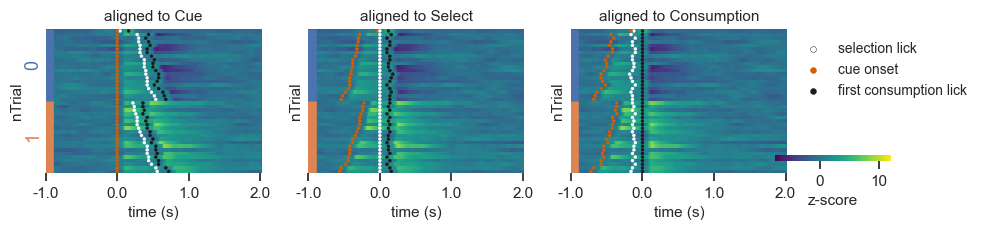

In [6]:
fig, ax = heatmaps.plot_heatmap_wrapper(trials_trimmed, 
                                        alignment_states=['Cue', 'Select', 'Consumption'],
                                        channel='grnL',
                                        win=(1,2),
                                        figsize=(10,2),
                                        task_variable='Reward',
                                        subsample=20)

### Simple demo of peak min/max quantification for ground truth testing

### Testing peak finding for ground true - min and max for consumption should be noisy (-1.5, 1.5), bounded at 0, and max and min for Cue should be (0, 1.5). Reward dependency of Consumption -- should be 0 opposite reward-evoked valence.

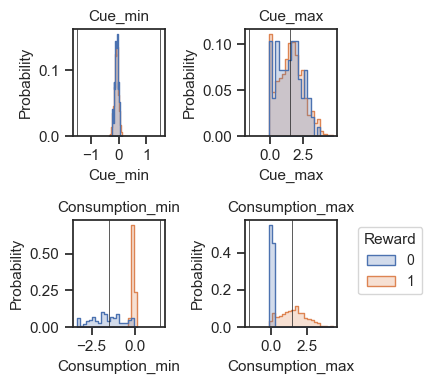

In [7]:
trials = sim_data.trials
trials.loc[trials.Reward<0, 'Reward'] = 0
timeseries = sim_data.session
timeseries = timeseries.rename(columns={'amplitudes':'z_amplitudes'})
win = (1,3)

for epoch in ['Cue', 'Consumption']:
    trials = align.align_photometry_to_event(trials, timeseries, channel='amplitudes',
                                                aligned_event=epoch, window=win, quantify_peaks=True)
        
# Now it's ok to start dropping trials because we've stored photometry snippets.
timeseries_trimmed, trials_trimmed = align.trim_trials_without_licks(timeseries, trials) 

fig, axs = plt.subplots(2,2, figsize=(5.5,4))
cols = ['Cue_min','Cue_max', 'Consumption_min', 'Consumption_max']
for legend, (ax, col) in enumerate(zip(axs.flatten(), cols), start=1):
    sns.histplot(data=trials_trimmed, 
                 x=col,
                 ax=ax,
                 hue='Reward',
                 stat='probability',
                 common_norm=False,
                 bins=20,
                 legend=legend==len(cols),
                 element='step')
    ax.axvline(x=1.5, color='k', lw=0.5)
    ax.axvline(x=-1.5, color='k', lw=0.5)
    ax.set(title=col)
legend = ax.get_legend()
legend.set(bbox_to_anchor=(2,1))
plt.tight_layout()

In [8]:
summary = {'max consumption rew': trials_trimmed.query('Reward==1').Consumption_max.mean(),
 'min consumption rew': trials_trimmed.query('Reward==1').Consumption_min.mean(),
 'max consumption NR': trials_trimmed.query('Reward==0').Consumption_max.mean(),
 'min consumption NR': trials_trimmed.query('Reward==0').Consumption_min.mean(),
 'max cue rew': trials_trimmed.query('Reward==1').Cue_max.mean(),
 'min cue rew': trials_trimmed.query('Reward==1').Cue_min.mean(),
 'max cue NR': trials_trimmed.query('Reward==0').Cue_max.mean(),
 'min cue NR': trials_trimmed.query('Reward==0').Cue_min.mean()}

for k, v in summary.items():
    print(f'{k}: {round(v, 2)}')

max consumption rew: 1.54
min consumption rew: -0.08
max consumption NR: 0.08
min consumption NR: -1.62
max cue rew: 1.53
min cue rew: -0.08
max cue NR: 1.45
min cue NR: -0.08


In [9]:
for epoch in ['Cue', 'Select', 'Consumption']:
    trials = align.align_photometry_to_event(trials, timeseries, channel='grnL',
                                                aligned_event=epoch, window=win, quantify_peaks=False)
        
# Now it's ok to start dropping trials because we've stored photometry snippets.
timeseries_trimmed, trials_trimmed = align.trim_trials_without_licks(timeseries, trials) 

peaks = group_peak_metrics(trials_trimmed,
                        grouping_levels=['Session'],
                        channel='grnL',
                        states=['Cue','Consumption'],
                        agg_funcs=['mean','min','max'],
                        offset=False)

peaks.loc[peaks.Reward<0, 'Reward'] = 0

### Test timing detection -- "neural events" are created at the time of behavior/task events and filtered with same distribution, so timing should be precise for both `amplitudes` (0), and `z` channel (lagged).

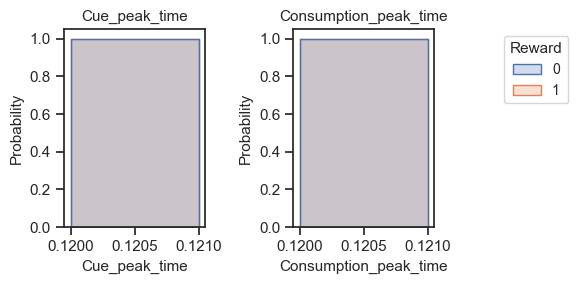

In [10]:
fig, axs = plt.subplots(ncols=2, figsize=(7,3))
cols = ['Cue_peak_time','Consumption_peak_time',]
for legend, (ax, col) in enumerate(zip(axs, cols), start=1):
    sns.histplot(data=peaks, 
                 x=col,
                 ax=ax,
                 hue='Reward',
                 stat='probability',
                 common_norm=False,
                 binwidth=0.001,
                 legend=legend==len(cols),
                 element='step')
    ax.set(title=col)
legend = ax.get_legend()
legend.set(bbox_to_anchor=(2,1))
plt.tight_layout()

### Example: Barplot with default layout, setting a palette.

defaulting to autofit axis limits


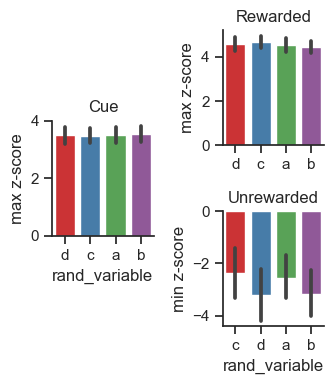

In [11]:
fig, ax = plot_peaks_wrapper(peaks, 
                             x_col='rand_variable',
                             plot_func=sns.barplot,
                             plot_func_kws={'palette':'Set1'},
                             metrics={'Cue':'max', 'reward':'max', 'no reward':'min'},
                            )

### Example 2: point plot with flattened layout of standard state set, plotting min values for all states.

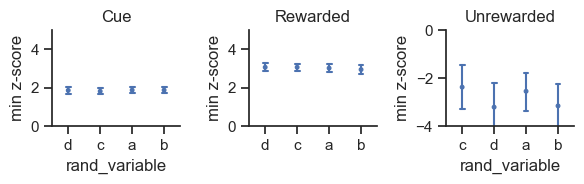

In [12]:
pointplot_kws = {'scale':0.4, 'errorbar':'ci', 'palette':None, 'capsize':0.15, 'errwidth':1.5,'join':False}

fig, ax = plot_peaks_wrapper(peaks, 
                             x_col='rand_variable',
                             plot_func=sns.pointplot,
                             plot_func_kws=pointplot_kws,
                             metrics='min',
                             flatten_layout=True,
                             axes_style={'Cue':(0,5), 'reward':(0,5), 'no reward':(-4,0)}
                            )

### Example: violinplots with and without outliers dropped

defaulting to autofit axis limits


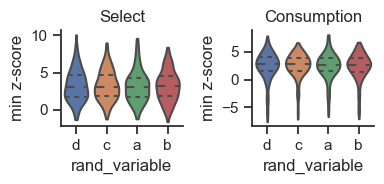

In [13]:
peaks = group_peak_metrics(trials_trimmed, 
                         grouping_levels=['Reward'],
                         channel='grnL',
                         agg_funcs=['max', 'min'],
                         states=['Select', 'Consumption'],
                         offset=False)

violinplot_kws = {'palette':None, 'cut':0, 'inner':'quartiles'}
fig, ax = plot_peaks_wrapper(peaks, 
                           x_col='rand_variable',
                           plot_func=sns.violinplot,
                           metrics='min',
                           flatten_layout=True,
                           plot_func_kws=violinplot_kws,
                           states=['Select', 'Consumption'], ignore_reward=True
                            )



defaulting to autofit axis limits
0.028 points removed as outliers
0.0 points removed as outliers
0.0 points removed as outliers
0.004 points removed as outliers
0.066 points removed as outliers
0.064 points removed as outliers
0.059 points removed as outliers
0.066 points removed as outliers


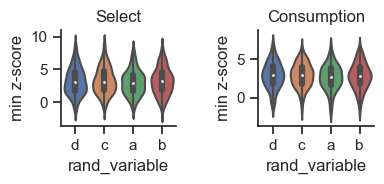

In [14]:
fig, ax = plot_peaks_wrapper(peaks, 
                           x_col='rand_variable',
                           plot_func=sns.violinplot,
                            metrics='min',
                            flatten_layout=True,
                            states=['Select', 'Consumption'], ignore_reward=True,
                            show_outliers=False
                            )